In [23]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Device configuration

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load the MNIST Dataset

In [7]:
# Define a transform to normalize the data (Preprocessing)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [8]:
dataiter=iter(trainloader)
images, labels=dataiter.next()

In [9]:
print(trainloader)
print(testloader)

In [10]:
print(trainset.data.size())
print(testset.data.size())

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


### Visualization of MNIST

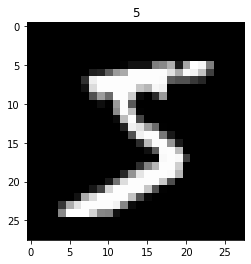

In [11]:
plt.imshow(trainset.data[0], cmap='gray')
plt.title('%i' % trainset.targets[0])
plt.show()

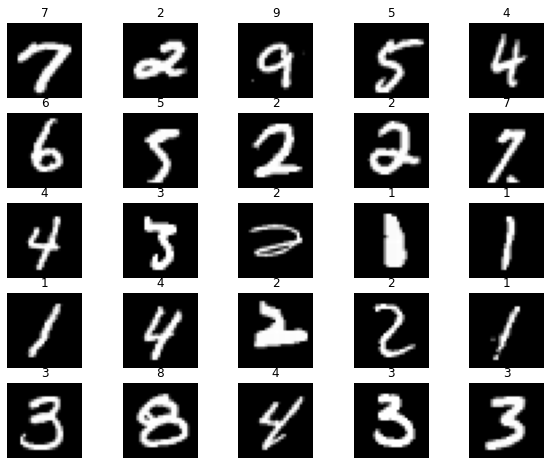

In [12]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [50]:
def view_classify(img, ps):

    ps = ps.cpu().data.numpy().squeeze()
    img= img.cpu().data.numpy()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.reshape(1, 28, 28).squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

### CNN model

In [36]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels= 16, kernel_size= 5, stride= 1, padding= 2),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 5, 1, 2),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2))
        self.out = nn.Linear(32 * 7 * 7, 10)            # output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.shape[0], -1)
        output = self.out(x)
        return output

cnn = CNN()
cnn.to(device)
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


### Loss and Optimization Function

In [57]:
loss_func = nn.CrossEntropyLoss()
print(loss_func)

optimizer = optim.Adam(cnn.parameters(), lr= 0.001)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)


### Train the model

In [58]:
epochs = 10
print_every = 40

def fit(model, trainloader, testloader, loss_func, optimizer, num_epochs, print_every):
    for epoch in range(num_epochs):

        #save checkpoint models in every 10th epoch
        if (epoch+1) % 10 == 0:
            torch.save(cnn.state_dict(), f'checkpoint_{epoch+1}.pth')

        current_loss = 0
        print(f"Epoch: {epoch+1}/{num_epochs}")

        for i, (images, labels) in enumerate(iter(trainloader)):
            images, labels = images.to(device), labels.to(device)   #for cuda 
            # images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad()
            
            output = model.forward(images)   # 1) Forward pass
            loss = loss_func(output, labels) # 2) Compute loss
            loss.backward()                  # 3) Backward pass
            optimizer.step()                 # 4) Update model
            
            current_loss += loss.item()
            
            if i % print_every == 0:
                loss_value = current_loss/print_every
                print(f"\tIteration: {i}\t Loss: {current_loss/print_every:.4f}")
                current_loss = 0

        model.eval()
        acc_list = []
        with torch.no_grad():
            for i, (images_test, labels_test) in enumerate(iter(testloader)):
                    images_test, labels_test = images_test.to(device), labels_test.to(device)
                    # images.resize_(images.size()[0], 784)
                    probability = F.softmax(model(images_test), dim=1)
                    pred = probability.argmax(dim=1)
                    acc = (pred == labels_test).sum() / len(labels_test)
                    acc_list.append(acc.item())     # need to add .item()
        print(f'Mean accuracy is {np.array(acc_list).mean()} after epoch {epoch+1}')

        model.train()



In [59]:
results = fit(cnn, trainloader, testloader, loss_func, optimizer, epochs, print_every)

Epoch: 1/10
	Iteration: 0	 Loss: 0.0578
	Iteration: 40	 Loss: 1.6359
	Iteration: 80	 Loss: 0.5271
	Iteration: 120	 Loss: 0.3107
	Iteration: 160	 Loss: 0.2660
	Iteration: 200	 Loss: 0.2002
	Iteration: 240	 Loss: 0.1728
	Iteration: 280	 Loss: 0.1999
	Iteration: 320	 Loss: 0.1557
	Iteration: 360	 Loss: 0.1260
	Iteration: 400	 Loss: 0.1277
	Iteration: 440	 Loss: 0.1299
	Iteration: 480	 Loss: 0.1100
	Iteration: 520	 Loss: 0.1401
	Iteration: 560	 Loss: 0.0991
	Iteration: 600	 Loss: 0.1034
	Iteration: 640	 Loss: 0.0997
	Iteration: 680	 Loss: 0.0952
	Iteration: 720	 Loss: 0.0890
	Iteration: 760	 Loss: 0.0976
	Iteration: 800	 Loss: 0.0903
	Iteration: 840	 Loss: 0.0663
	Iteration: 880	 Loss: 0.0826
	Iteration: 920	 Loss: 0.0684
Mean accuracy is 0.9785031847133758 after epoch 1
Epoch: 2/10
	Iteration: 0	 Loss: 0.0007
	Iteration: 40	 Loss: 0.0602
	Iteration: 80	 Loss: 0.0739
	Iteration: 120	 Loss: 0.0629
	Iteration: 160	 Loss: 0.0646
	Iteration: 200	 Loss: 0.0628
	Iteration: 240	 Loss: 0.0556
	Ite

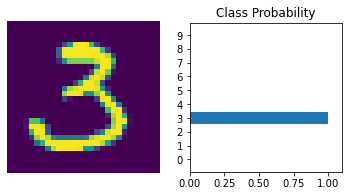

In [61]:
images, labels = next(iter(testloader))
images=images.to(device)
labels=labels.to(device)
image=images[1]    
#images.resize_(images.shape[0], 1, 784) 
logits = cnn.forward(image.view(1,1,28,28))
ps = F.softmax(logits, dim=1)
view_classify(image.view(1, 28, 28), ps)